In [1]:
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt

### MRI Images

In [ ]:
df_mri = pd.read_csv("./Key_MRI_30Nov2025.csv")

# Ensure  image_date in datetime format
df_mri["image_date"] = pd.to_datetime(df_mri["image_date"])


In [15]:
df_mri.columns

Index(['image_id', 'subject_id', 'image_visit', 'image_date', 'series_type',
       'mri_protocol_phase', 'series_description', 'acceleration',
       'acquisition_type', 'acquisition_plane', 'number_volumes',
       'slices_per_volume', 'slice_thickness', 'scanner_manufacturer',
       'scanner_model', 'software_version', 'magnetic_field_strength',
       'receive_coil_name', 'study_instance_uid', 'series_instance_uid',
       'loni_study', 'loni_series', 'loni_image', 'diagnosis'],
      dtype='object')

In [3]:
# Filter for 3T
df_mri = df_mri[ df_mri["magnetic_field_strength"] == 3]
print(len(df_mri))

# Filter for T1 weighted
df_mri = df_mri[ df_mri["series_type"] == "T1w"]
print(len(df_mri))

# Filter for 3d 
df_mri = df_mri[ df_mri["acquisition_type"] == "3D"]
print(len(df_mri))


81050
14470
14286


In [11]:
df_mri["subject_id"].unique()

array(['002_S_0413', '002_S_0729', '002_S_1261', ..., '941_S_6962',
       '941_S_7041', '082_S_7117'], shape=(1163,), dtype=object)

### PET Images

In [4]:
df_pet = pd.read_csv("./Key_PET_06Dec2025.csv")

# Ensure image_date is in datetime format
df_pet["image_date"] = pd.to_datetime(df_pet["image_date"])

print(len(df_pet))

9980


In [5]:
# Filter for FDG-PET
df_pet["radiopharmaceutical"].value_counts()

df_pet = df_pet[ df_pet["radiopharmaceutical"] == "18F-FDG"]

print(len(df_pet))

2699


In [6]:
# Filter MRI scans for patients who have PET scans
pet_patients = df_pet["subject_id"].unique().tolist()

df_mri = df_mri[ df_mri["subject_id"].isin(pet_patients) ]
len(df_mri)


9979

### Add diagnoses

In [7]:

# Read diagnostic summary
df_diagnostic = pd.read_csv("./DXSUM_13Aug2025.csv")

# Ensure EXAMDATE has datetime format
df_diagnostic["EXAMDATE"] = pd.to_datetime(df_diagnostic["EXAMDATE"])

df_diagnostic.head()

PHASE        PTID  RID VISCODE VISCODE2   EXAMDATE  DIAGNOSIS  DXNORM  \
0  ADNI1  011_S_0002    2      bl       bl 2005-09-29        1.0     1.0   
1  ADNI1  011_S_0003    3      bl       bl 2005-09-30        3.0    -4.0   
2  ADNI1  011_S_0005    5      bl       bl 2005-09-30        1.0     1.0   
3  ADNI1  011_S_0008    8      bl       bl 2005-09-30        1.0     1.0   
4  ADNI1  022_S_0007    7      bl       bl 2005-10-06        3.0    -4.0   

   DXNODEP  DXMCI  ... DXODES  DXCONFID  ID  SITEID    USERDATE  USERDATE2  \
0     -4.0   -4.0  ...   -4.0       4.0   2     107  2005-10-01        NaN   
1     -4.0   -4.0  ...   -4.0       3.0   4     107  2005-10-01        NaN   
2     -4.0   -4.0  ...   -4.0       4.0   6     107  2005-10-01        NaN   
3     -4.0   -4.0  ...   -4.0       3.0   8     107  2005-10-01        NaN   
4     -4.0   -4.0  ...   -4.0       4.0  10      10  2005-10-06        NaN   

   DD_CRF_VERSION_LABEL  LANGUAGE_CODE HAS_QC_ERROR           update_stamp  
0                   NaN            NaN          NaN  2005-10-01 00:00:00.0  
1                   NaN            NaN          NaN  2005-10-01 00:00:00.0  
2                   NaN            NaN          NaN  2005-10-01 00:00:00.0  
3                   NaN            NaN          NaN  2005-10-01 00:00:00.0  
4                   NaN            NaN          NaN  2005-10-06 00:00:00.0  

[5 rows x 41 columns]

In [8]:
# Add diagnoses to MRI table

# tolerance in days between scan date and exam date
tolerance = 60

entries = []

for index, row in df_mri.iterrows():
    
    subj_id = row["subject_id"]
    mri_date = row["image_date"]
    
    # Get subject visits
    subj_visits = df_diagnostic[ df_diagnostic["PTID"] == subj_id]
    
    # Compute days difference
    subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - mri_date).dt.days
    
    # Choose only those under the tolerance
    match = subj_visits[ subj_visits["diff_days"] <= tolerance]
    
    
    # If visit under tolerance is found, assign diagnosis of closest visit
    if not match.empty:
        
        # Get temporally closest visit
        visit = match.sort_values("diff_days").iloc[0]
        
        # Append image id and diagnosis to entries
        entries.append({
            "image_id":row["image_id"],
            "diagnosis":visit["DIAGNOSIS"]
        })
        
    # Otherwise, try what follows:
    else:
   
        # Separate visits before and after 
        subj_visits_before = subj_visits[ subj_visits["diff_days"] < 0]
        subj_visits_after = subj_visits[ subj_visits["diff_days"] >= 0]
        
        # Make sure that there are both visits before and after 
        if subj_visits_after.empty or subj_visits_before.empty:
            continue
        
        # Turn days difference into absolute values
        subj_visits_before["diff_days"] = abs(subj_visits_before["diff_days"])
        
        # Get closest visit before
        visit_before = subj_visits_before.sort_values("diff_days").iloc[0]
        
        # Get closest visit after 
        visit_after = subj_visits_after.sort_values("diff_days").iloc[0]
        
        # If diagnosis has not changed between the two visit, then 
        # at the time of the scan (in between the visits) the diagnosis must agree.
        if visit_after["DIAGNOSIS"] == visit_before["DIAGNOSIS"]:
            
            entries.append({
                "image_id":row["image_id"],
                "diagnosis":visit_after["DIAGNOSIS"]
            }) 

/home/cestari/ipykernel_595272/2830918960.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - mri_date).dt.days
/home/cestari/ipykernel_595272/2830918960.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - mri_date).dt.days
/home/cestari/ipykernel_595272/2830918960.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [9]:
# Create dataframe to attach to MRI df
diagnosis_col = pd.DataFrame(entries)

# Merge 
df_mri = pd.merge(df_mri, diagnosis_col, on="image_id")

print(len(df_mri))
df_mri.head()

9911


image_id  subject_id image_visit image_date series_type mri_protocol_phase  \
0     30119  002_S_0413         m06 2006-11-15         T1w              ADNI1   
1     30118  002_S_0413         m06 2006-11-15         T1w              ADNI1   
2     55782  002_S_0413         m12 2007-06-01         T1w              ADNI1   
3     55783  002_S_0413         m12 2007-06-01         T1w              ADNI1   
4    142972  002_S_0413         m36 2009-04-30         T1w              ADNI1   

  series_description   acceleration acquisition_type acquisition_plane  ...  \
0             MPRAGE  Unaccelerated               3D          Sagittal  ...   
1             MPRAGE  Unaccelerated               3D          Sagittal  ...   
2             MPRAGE  Unaccelerated               3D          Sagittal  ...   
3      MPRAGE REPEAT  Unaccelerated               3D          Sagittal  ...   
4             MPRAGE  Unaccelerated               3D          Sagittal  ...   

   scanner_model                            software_version  \
0         Intera                  1.5.4\1.5.4.3\Gyroscan PMS   
1         Intera                  1.5.4\1.5.4.3\Gyroscan PMS   
2         Intera                  2.1.3\2.1.3.3\Gyroscan PMS   
3         Intera                  2.1.3\2.1.3.3\Gyroscan PMS   
4         Intera  2.6.1\2.6.1.1\PMS1.1 MIMIT EVIIMDictionary   

   magnetic_field_strength receive_coil_name  \
0                      3.0        SENSE-Head   
1                      3.0        SENSE-Head   
2                      3.0      SENSE-Head-8   
3                      3.0      SENSE-Head-8   
4                      3.0      SENSE-Head-8   

                            study_instance_uid  \
0  2.16.124.113543.6006.99.0219127259789971954   
1  2.16.124.113543.6006.99.0219127259789971954   
2  2.16.124.113543.6006.99.2202581879307062919   
3  2.16.124.113543.6006.99.2202581879307062919   
4  2.16.124.113543.6006.99.0863027524157170523   

                            series_instance_uid  loni_study loni_series  \
0   2.16.124.113543.6006.99.5125095124197887953        5954       22684   
1   2.16.124.113543.6006.99.5124038306382838061        5954       22683   
2   2.16.124.113543.6006.99.8411086160285492109        9095       32945   
3   2.16.124.113543.6006.99.2677107232272006918        9095       32946   
4  2.16.124.113543.6006.99.08843503603493170480       21262       66926   

  loni_image diagnosis  
0      30119       1.0  
1      30118       1.0  
2      55782       1.0  
3      55783       1.0  
4     142972       1.0  

[5 rows x 24 columns]

In [10]:
# Add diagnoses to PET table

# tolerance in days between scan date and exam date
tolerance = 60

entries = []

for index, row in df_pet.iterrows():
    
    subj_id = row["subject_id"]
    pet_date = row["image_date"]
    
    # Get subject visits
    subj_visits = df_diagnostic[ df_diagnostic["PTID"] == subj_id]
    
    # Compute days difference
    subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - pet_date).dt.days
    
    # Choose only those under the tolerance
    match = subj_visits[ subj_visits["diff_days"] <= tolerance]
    
    
    # If visit under tolerance is found, assign diagnosis of closest visit
    if not match.empty:
        
        # Get temporally closest visit
        visit = match.sort_values("diff_days").iloc[0]
        
        # Append image id and diagnosis to entries
        entries.append({
            "image_id":row["image_id"],
            "diagnosis":visit["DIAGNOSIS"]
        })
        
    # Otherwise, try what follows:
    else:
   
        # Separate visits before and after 
        subj_visits_before = subj_visits[ subj_visits["diff_days"] < 0]
        subj_visits_after = subj_visits[ subj_visits["diff_days"] >= 0]
        
        # Make sure that there are both visits before and after 
        if subj_visits_after.empty or subj_visits_before.empty:
            continue
        
        # Turn days difference into absolute values
        subj_visits_before["diff_days"] = abs(subj_visits_before["diff_days"])
        
        # Get closest visit before
        visit_before = subj_visits_before.sort_values("diff_days").iloc[0]
        
        # Get closest visit after 
        visit_after = subj_visits_after.sort_values("diff_days").iloc[0]
        
        # If diagnosis has not changed between the two visit, then 
        # at the time of the scan (in between the visits) the diagnosis must agree.
        if visit_after["DIAGNOSIS"] == visit_before["DIAGNOSIS"]:
            
            entries.append({
                "image_id":row["image_id"],
                "diagnosis":visit_after["DIAGNOSIS"]
            }) 

/home/cestari/ipykernel_595272/746348272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - pet_date).dt.days
/home/cestari/ipykernel_595272/746348272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_visits["diff_days"] =  (subj_visits["EXAMDATE"] - pet_date).dt.days
/home/cestari/ipykernel_595272/746348272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [14]:
# Create dataframe to attach to MRI df
diagnosis_col = pd.DataFrame(entries)

# Merge 
df_pet = pd.merge(df_pet, diagnosis_col, on="image_id")

print(len(df_pet))
df_pet.head()

2683


image_id  subject_id image_visit image_date tau_pet amyloid_pet  \
0   1597990  037_S_1421         m12 2008-09-17     NaN         NaN   
1   1598056  037_S_1421         m18 2009-05-13     NaN         NaN   
2   1598115  037_S_1421         m36 2010-09-24     NaN         NaN   
3   1598209  037_S_1421         m06 2008-02-20     NaN         NaN   
4   1598218  037_S_1421          bl 2007-09-04     NaN         NaN   

  radiopharmaceutical                                   pet_description  \
0             18F-FDG  Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res   
1             18F-FDG  Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res   
2             18F-FDG  Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res   
3             18F-FDG  Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res   
4             18F-FDG  Coreg, Avg, Std Img and Vox Siz, Uniform 6mm Res   

   diagnosis  
0        2.0  
1        2.0  
2        2.0  
3        2.0  
4        2.0

### Match MRI and PET images

In [15]:
# Match each MRI with temporally closest PET image.
# Add days difference into the dataframe for later filtering. 


entries = []

for index, row in df_mri.iterrows():
    
    ptid = row["subject_id"]
    mri_date = row["image_date"]
    diagnosis = row["diagnosis"]
    
    # Get pet scans of subject
    subj_pet = df_pet[ df_pet["subject_id"] == ptid]
    
    # and  with the same diagnosis as the mri.
    subj_pet = subj_pet[ subj_pet["diagnosis"] == diagnosis]
    
    # Add difference days column 
    subj_pet["diff_days"] = abs(subj_pet["image_date"] - mri_date).dt.days
    
    # Filter those under tolerance
    #match = subj_pet[ subj_pet["diff_days"] <= tolerance]
    
    match = subj_pet
    
    if not match.empty:
        
        # Get closest pet scan
        pet_scan = match.sort_values("diff_days").iloc[0]
        
        entries.append({
            "mri_id":row["image_id"],
            "pet_id":pet_scan["image_id"],
            "diagnosis":diagnosis,
            "days_diff":pet_scan["diff_days"]
        })

In [16]:
df_matched = pd.DataFrame(entries)
df_matched.head()

mri_id   pet_id  diagnosis  days_diff
0   30119  1592893        1.0       1675
1   30118  1592893        1.0       1675
2   55782  1592893        1.0       1477
3   55783  1592893        1.0       1477
4  142972  1592893        1.0        778

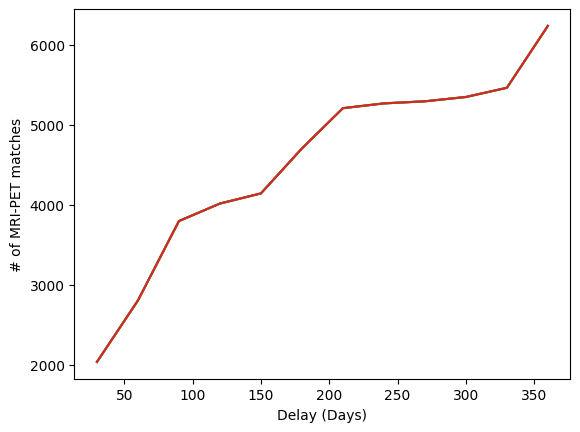

In [17]:
# Visualize empirical cumulative distribution of days difference between PET and MRI:

thresholds = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]

counts = [ df_matched[ df_matched["days_diff"] <= t].count() for t in thresholds]

plt.plot(thresholds, counts)
plt.xlabel("Delay (Days)")
plt.ylabel("# of MRI-PET matches")
plt.show()

In [ ]:
# Unique pet ids 
df_matched["pet_id"].unique()

array([1592893, 1593118, 1592958, ..., 1614518, 1614530, 1680540],
      shape=(1584,))

In [20]:
# Print them in a string separated by commas, so it's downloadable from ADNI website

", ".join([ str(id) for id in df_matched["pet_id"].unique()])

'1592893, 1593118, 1592958, 1592998, 1593156, 1593805, 1593783, 1593848, 1593798, 1594283, 1595065, 1595059, 1596189, 1596242, 1596146, 1596152, 1596179, 1596129, 1596156, 1596215, 1596519, 1596727, 1597101, 1597240, 1597238, 1597197, 1600481, 1601062, 1602131, 1602032, 1602072, 1592036, 1592896, 1592916, 1592917, 1593108, 1593116, 1593107, 1592952, 1593152, 1593079, 1592956, 1593131, 1593080, 1593024, 1593083, 1593114, 1592960, 1593139, 1593109, 1592961, 1593103, 1593155, 1593119, 1593104, 1593063, 1593031, 1593115, 1593045, 1593110, 1593022, 1593038, 1593023, 1593067, 1593029, 1593111, 1593106, 1593053, 1593136, 1593028, 1593055, 1592963, 1593098, 1593075, 1593011, 1593020, 1593120, 1593417, 1593436, 1593387, 1593449, 1593581, 1593485, 1593570, 1593574, 1593479, 1593562, 1593568, 1593490, 1593629, 1593416, 1593640, 1593452, 1593425, 1593523, 1593655, 1593651, 1593551, 1593530, 1593537, 1593402, 1593577, 1593478, 1593662, 1593626, 1593461, 1593579, 1593557, 1593460, 1593622, 1593484, 

### Check which MRI images have already been preprocessed

In [24]:
# Open the dataset csv
df_dataset = pd.read_csv("/project/aereditato/abhat/adni-mri-classification/data/preprocessing_dicom_spm_2/FINAL_master_dataset_3T.csv")
df_dataset.head()

filepath  rid   scan_date  \
0  /project/aereditato/abhat/adni-mri-classificat...  514  2008-06-19   
1  /project/aereditato/abhat/adni-mri-classificat...  514  2009-06-12   
2  /project/aereditato/abhat/adni-mri-classificat...  514  2008-06-19   
3  /project/aereditato/abhat/adni-mri-classificat...  514  2009-06-12   
4  /project/aereditato/abhat/adni-mri-classificat...  514  2007-06-07   

    exam_date  diagnosis  
0  2008-06-11        2.0  
1  2009-06-12        2.0  
2  2008-06-11        2.0  
3  2009-06-12        2.0  
4  2007-06-06        2.0

In [25]:
# Extract the image ids from the paths
image_ids = [ int(re.search(r"_I([0-9]+)_?.*.nii", s).group(1)) for s in df_dataset["filepath"]]
print(len(image_ids))
print(image_ids)

10391
[110402, 145791, 110401, 145792, 56536, 83708, 83709, 56535, 159636, 84541, 127606, 104941, 84539, 159635, 104942, 127605, 84540, 55543, 55542, 113446, 62251, 62252, 146834, 113447, 146835, 81019, 55383, 158366, 134238, 107900, 29859, 29861, 55384, 107901, 158365, 29860, 81020, 134239, 128600, 82080, 51401, 26207, 82079, 128599, 26206, 51400, 86268, 86270, 56645, 86269, 56644, 28030, 128980, 128978, 28029, 82254, 128979, 82255, 17619, 35240, 112817, 57021, 17620, 57020, 112818, 35239, 31868, 85324, 55475, 55476, 160613, 160615, 85323, 108920, 31869, 160614, 108921, 160757, 130146, 160758, 130147, 147118, 147119, 168101, 168100, 93763, 93762, 32130, 32131, 16848, 108864, 85621, 16847, 85620, 108863, 90150, 135175, 135176, 90149, 129502, 84173, 129503, 84174, 84258, 33725, 129847, 33724, 129846, 84259, 89320, 115279, 147841, 20023, 89319, 115280, 58874, 34480, 34481, 20024, 147842, 84989, 132165, 31834, 84988, 31833, 132164, 84276, 131092, 55834, 84275, 131091, 55835, 55710, 55709,

In [26]:
# Check if they are present in df_matched
df_final = df_matched[ df_matched["mri_id"].isin(image_ids)]
df_final

mri_id   pet_id  diagnosis  days_diff
8       153075  1593118        2.0        350
9       153076  1593118        2.0        350
16      137716  1592998        2.0        776
17      137717  1592998        2.0        776
22       32327  1593805        2.0       1575
...        ...      ...        ...        ...
9814  11359849  1598885        2.0       2872
9815  11362219  1594140        3.0       2296
9816  11362223  1594140        3.0       2296
9820  11393600  1600056        1.0       4449
9821  11393601  1600056        1.0       4449

[6937 rows x 4 columns]

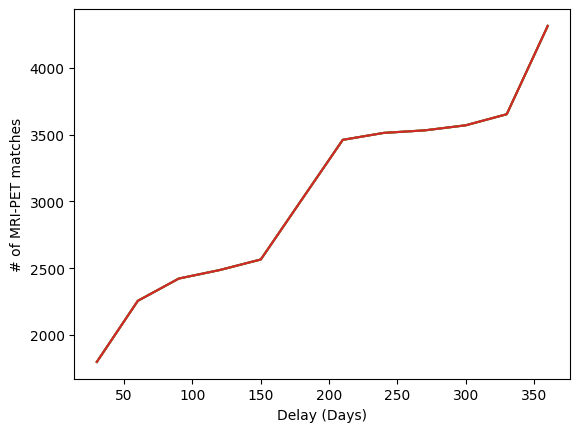

In [27]:
# Visualize empirical cumulative distribution of days difference between PET and MRI:

thresholds = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]

counts = [ df_final[ df_final["days_diff"] <= t].count() for t in thresholds]

plt.plot(thresholds, counts)
plt.xlabel("Delay (Days)")
plt.ylabel("# of MRI-PET matches")
plt.show()

In [29]:
# Save matched dataframe to .csv 
df_final.to_csv("mri_pet_pairs.csv")